In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from tkinter import Tk, filedialog
from torch.utils.data import DataLoader, TensorDataset

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# FILE SELECTION (Multiple CSVs)
# -------------------------------
Tk().withdraw()
file_paths = filedialog.askopenfilenames(title="Select CSV Files", filetypes=[("CSV Files", "*.csv")])
datasets = [pd.read_csv(file) for file in file_paths]
file_names = [os.path.basename(file) for file in file_paths]

# Display Dataset Information
dataset_info = pd.DataFrame({
    "File Name": file_names,
    "Rows": [df.shape[0] for df in datasets],
    "Columns": [df.shape[1] for df in datasets],
    "Numeric Columns": [list(df.select_dtypes(include=[np.number]).columns) for df in datasets]
})
print("\nDataset Info:\n", dataset_info)

# -------------------------------
# SIGNAL PREPROCESSING & PLOTTING
# -------------------------------
def moving_average_filter(signal, window_size=50):
    return np.convolve(signal, np.ones(window_size) / window_size, mode="same")

def detect_outliers(signal, threshold=3):
    z_scores = np.abs(zscore(signal))
    return np.where(z_scores > threshold)[0]

# Process each dataset
for i, df in enumerate(datasets):
    numeric_cols = dataset_info.loc[i, "Numeric Columns"]

    if len(numeric_cols) < 2:
        print(f"Skipping {file_names[i]} (Not enough numeric columns)")
        continue

    for col in numeric_cols:
        original_signal = df[col][:1000]
        baseline = moving_average_filter(original_signal)
        corrected_signal = original_signal - baseline
        outliers = detect_outliers(corrected_signal)

        plt.figure(figsize=(12, 5))
        plt.title(f"Original vs Processed Signal - {col} ({file_names[i]})")
        plt.plot(original_signal, label="Original", alpha=0.5)
        plt.plot(corrected_signal, label="Corrected", linestyle="dashed", color="red")
        plt.scatter(outliers, corrected_signal[outliers], color='black', label="Outliers", marker='o')
        plt.legend()
        plt.show()

        # Replace outliers with median value
        median_value = np.median(corrected_signal)
        df.loc[outliers, col] = median_value

# -------------------------------
# DATA PREPARATION
# -------------------------------
X_list, y_list = [], []
for df in datasets:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) < 2:
        continue
    X_list.append(df[numeric_cols[:-1]].values)
    y_list.append(df[numeric_cols[-1]].values)

if not X_list or not y_list:
    raise ValueError("No valid numeric data found in selected CSV files.")

X = np.array(X_list, dtype=object)
y = np.array(y_list, dtype=object)

# Find max sequence length & pad sequences
max_length = max(len(seq) for seq in X)
X_padded = np.array([np.pad(seq, ((0, max_length - len(seq)), (0, 0)), mode='constant') for seq in X], dtype=np.float32)
y_padded = np.array([np.pad(seq, (0, max_length - len(seq)), mode='constant') for seq in y], dtype=np.float32)

# Normalize Data
scaler = StandardScaler()
X_padded = np.array([scaler.fit_transform(x) for x in X_padded])

# Train-test split
if len(X_padded) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)
else:
    print("⚠ Warning: Not enough samples for train-test split. Using all data for training.")
    X_train, y_train = X_padded, y_padded
    X_test, y_test = X_padded, y_padded  # Dummy assignment for compatibility

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)  # Ensure correct shape

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# -------------------------------
# BUILD & TRAIN LSTM MODEL
# -------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc(lstm_out)  # Output full sequence
        return x

lstm_model = LSTMModel(X_train_tensor.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train LSTM
losses = []
for epoch in range(100):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch in [10, 50, 75, 100]:
        print(f"Epoch {epoch}: Loss={loss.item()}")

plt.plot(losses)
plt.title("LSTM Training Loss")
plt.show()

# -------------------------------
# BUILD & TRAIN TRANSFORMER MODEL (FIXED)
# -------------------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads=4, hidden_dim=64, output_dim=1, dropout=0.2):
        super(TransformerModel, self).__init__()

        # Ensure input_dim is divisible by num_heads
        valid_heads = [h for h in range(1, input_dim + 1) if input_dim % h == 0]
        num_heads = max([h for h in valid_heads if h <= num_heads], default=1)  # Choose the largest valid num_heads

        print(f"Using {num_heads} attention heads for input dimension {input_dim}")

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, 
                                                        nhead=num_heads, 
                                                        dim_feedforward=hidden_dim * 2, 
                                                        dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # Reshape to (seq_len, batch, input_dim)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Reshape back to (batch, seq_len, input_dim)
        x = self.fc(x)
        return x

transformer_model = TransformerModel(X_train_tensor.shape[2]).to(device)

# Train Transformer
losses = []
for epoch in range(100):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = transformer_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch in [10, 50, 75, 100]:
        print(f"Epoch {epoch}: Loss={loss.item()}")

plt.plot(losses)
plt.title("Transformer Training Loss")
plt.show()


Using device: cuda

Dataset Info:
                          File Name  Rows  Columns  \
0  rakshita_5min_NB_10_02_2025.csv  4575        6   
1   rakshitha AM_5min_NB_19_02.csv  5388        6   

                                     Numeric Columns  
0  [Sensor1_Temp, Sensor1_Pressure, Sensor1_Humid...  
1  [Sensor1_Temp, Sensor1_Pressure, Sensor1_Humid...  


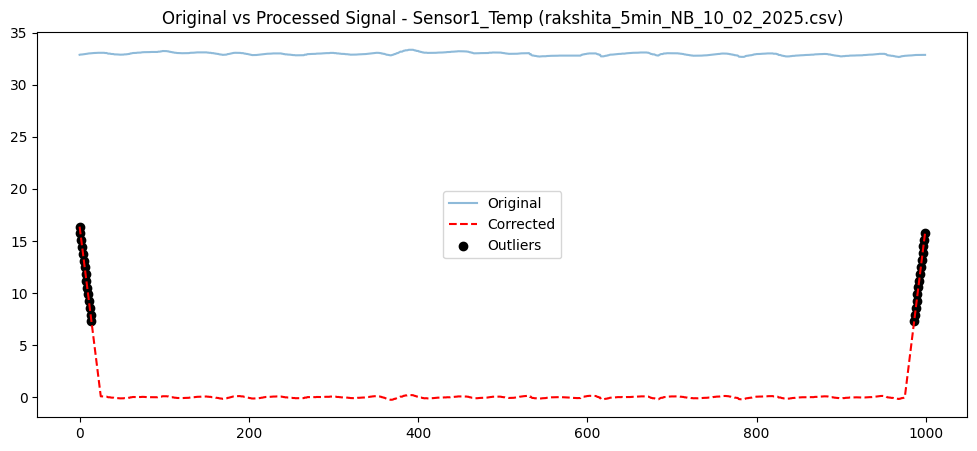

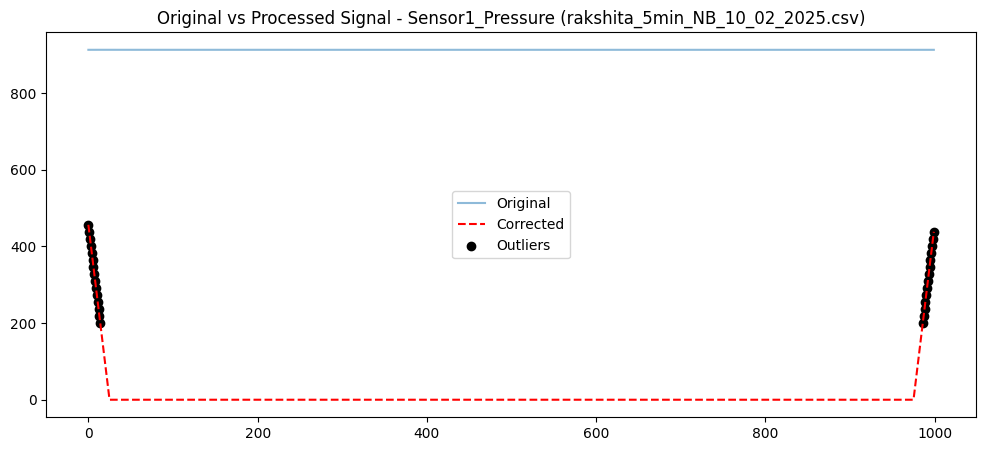

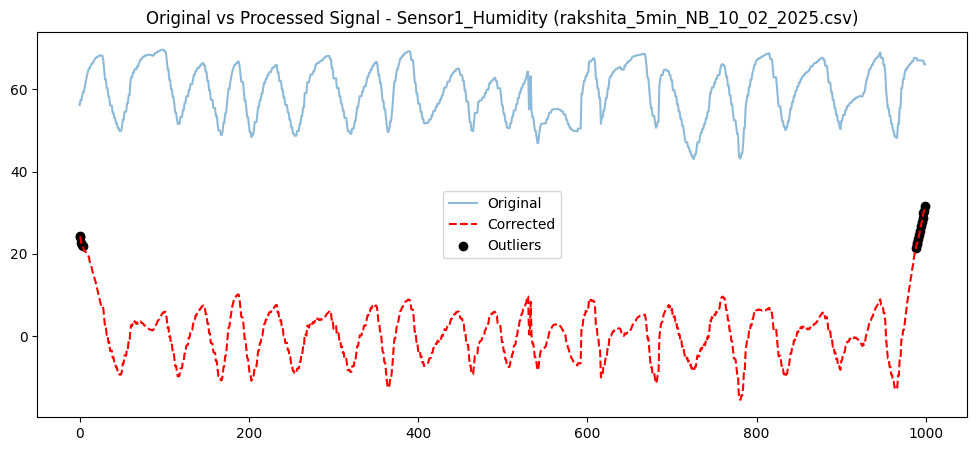

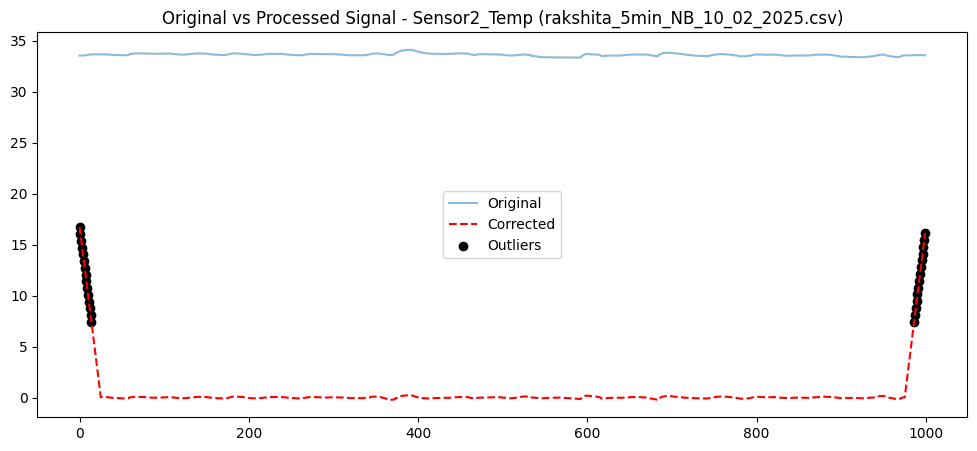

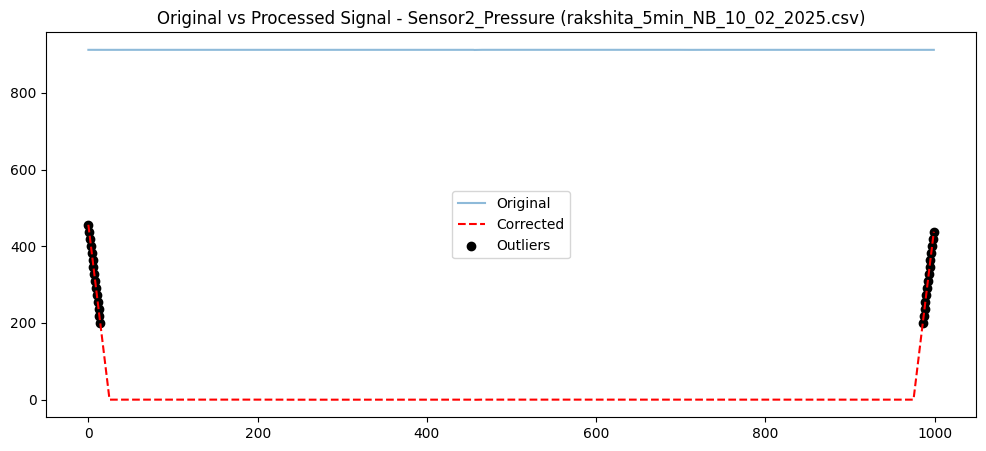

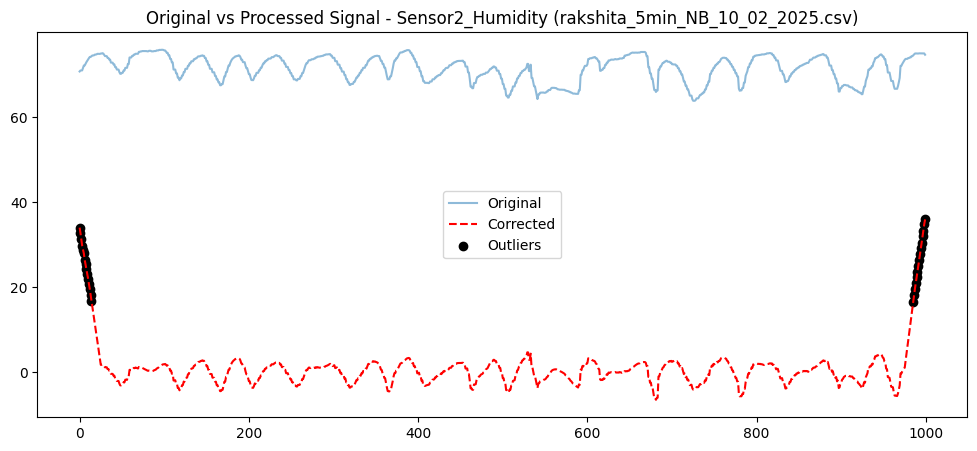

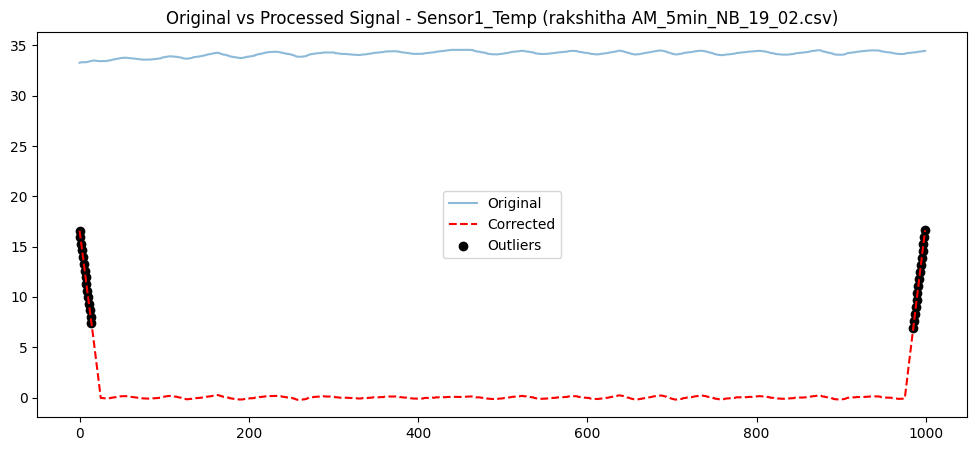

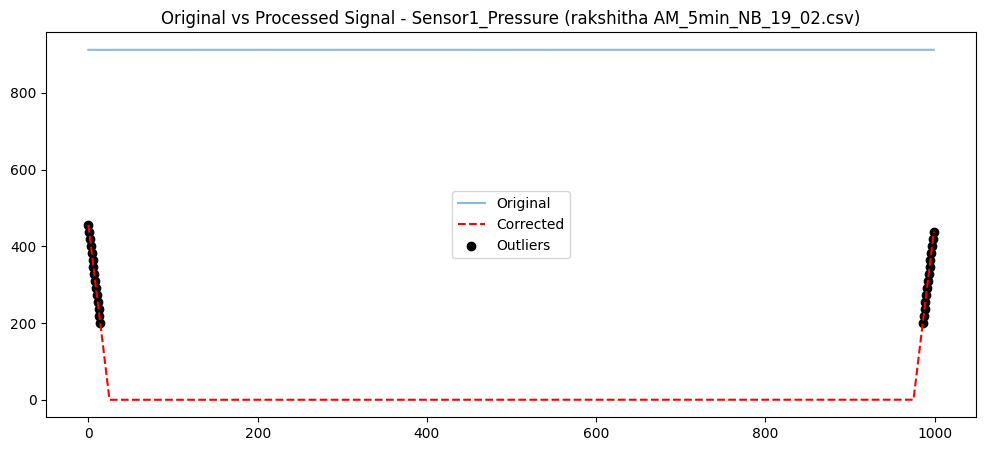

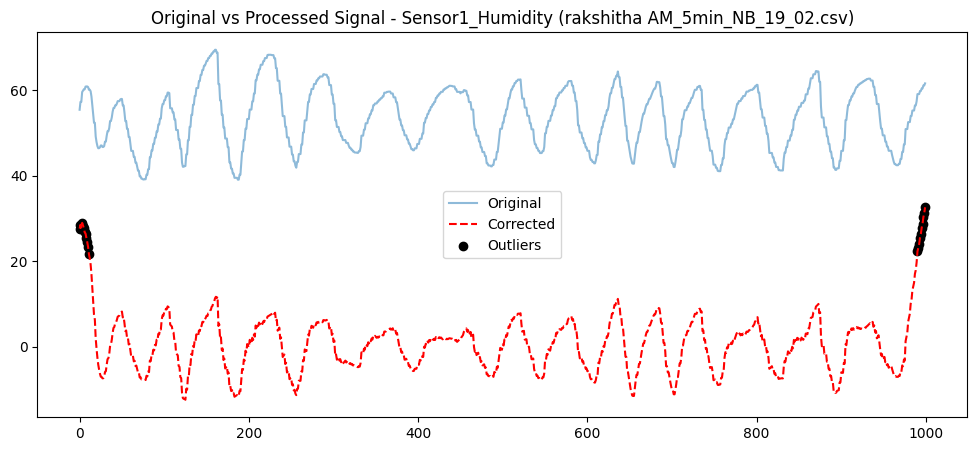

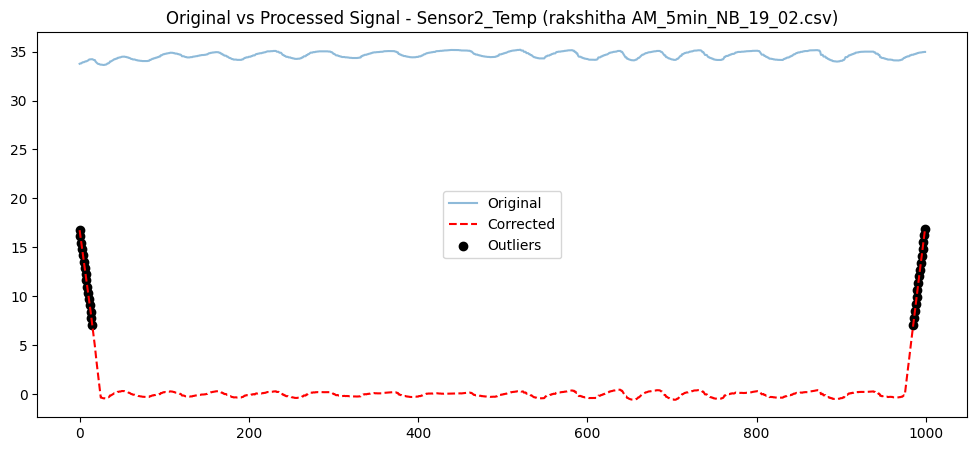

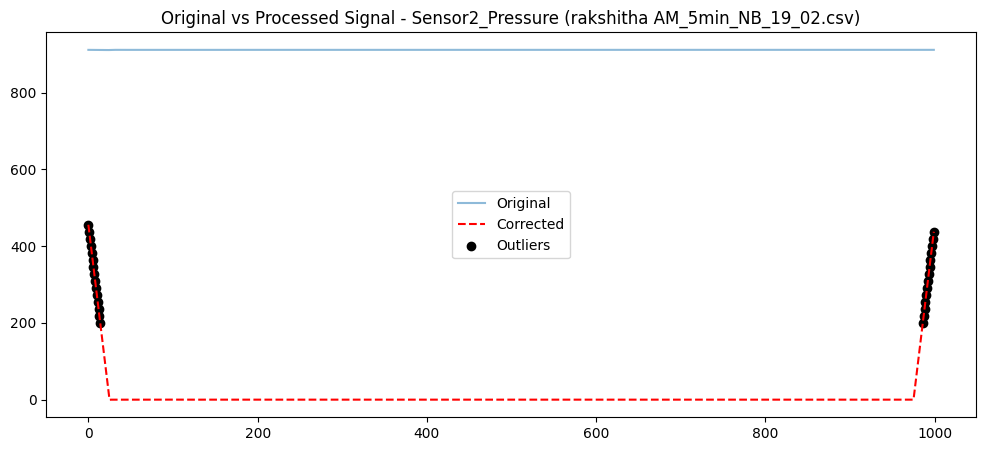

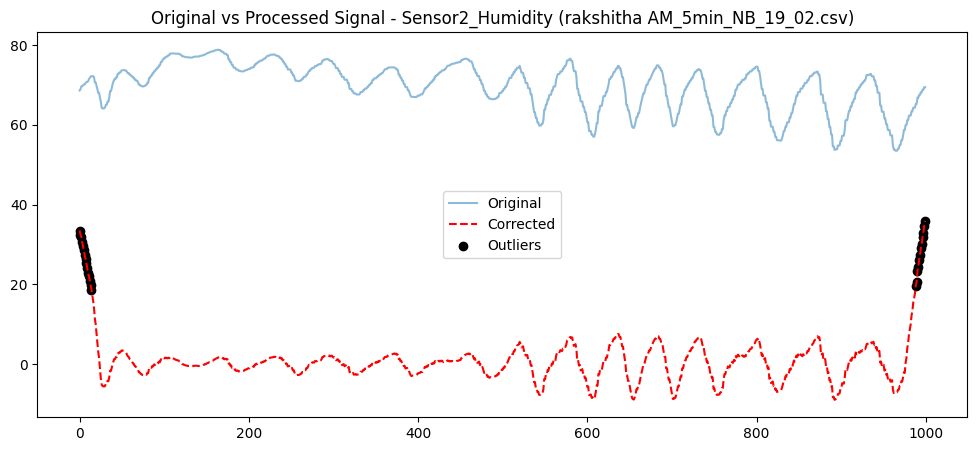

Epoch 10: Loss=4551.529296875
Epoch 50: Loss=3990.44189453125
Epoch 75: Loss=3672.148193359375


AssertionError: embed_dim must be divisible by num_heads

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from tkinter import Tk, filedialog
from torch.utils.data import DataLoader, TensorDataset

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# FILE SELECTION (Multiple CSVs)
# -------------------------------
Tk().withdraw()
file_paths = filedialog.askopenfilenames(title="Select CSV Files", filetypes=[("CSV Files", "*.csv")])
datasets = [pd.read_csv(file) for file in file_paths]
file_names = [os.path.basename(file) for file in file_paths]

# Display Dataset Information
dataset_info = pd.DataFrame({
    "File Name": file_names,
    "Rows": [df.shape[0] for df in datasets],
    "Columns": [df.shape[1] for df in datasets],
    "Numeric Columns": [list(df.select_dtypes(include=[np.number]).columns) for df in datasets]
})
print("\nDataset Info:\n", dataset_info)

# -------------------------------
# SIGNAL PREPROCESSING & PLOTTING
# -------------------------------
def moving_average_filter(signal, window_size=50):
    return np.convolve(signal, np.ones(window_size) / window_size, mode="same")

def detect_outliers(signal, threshold=3):
    z_scores = np.abs(zscore(signal))
    return np.where(z_scores > threshold)[0]

# Process each dataset
for i, df in enumerate(datasets):
    numeric_cols = dataset_info.loc[i, "Numeric Columns"]

    if len(numeric_cols) < 2:
        print(f"Skipping {file_names[i]} (Not enough numeric columns)")
        continue

    for col in numeric_cols:
        original_signal = df[col][:1000]
        baseline = moving_average_filter(original_signal)
        corrected_signal = original_signal - baseline
        outliers = detect_outliers(corrected_signal)

        plt.figure(figsize=(12, 5))
        plt.title(f"Original vs Processed Signal - {col} ({file_names[i]})")
        plt.plot(original_signal, label="Original", alpha=0.5)
        plt.plot(corrected_signal, label="Corrected", linestyle="dashed", color="red")
        plt.scatter(outliers, corrected_signal[outliers], color='black', label="Outliers", marker='o')
        plt.legend()
        plt.show()

        # Replace outliers with median value
        median_value = np.median(corrected_signal)
        df.loc[outliers, col] = median_value

# -------------------------------
# DATA PREPARATION
# -------------------------------
X_list, y_list = [], []
for df in datasets:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) < 2:
        continue
    X_list.append(df[numeric_cols[:-1]].values)
    y_list.append(df[numeric_cols[-1]].values)

if not X_list or not y_list:
    raise ValueError("No valid numeric data found in selected CSV files.")

# Find max sequence length & pad sequences
max_length = max(len(seq) for seq in X_list)
X_padded = np.array([np.pad(seq, ((0, max_length - len(seq)), (0, 0)), mode='constant') for seq in X_list], dtype=np.float32)
y_padded = np.array([np.pad(seq, (0, max_length - len(seq)), mode='constant') for seq in y_list], dtype=np.float32)

# Normalize Data
scaler = StandardScaler()
X_padded = np.array([scaler.fit_transform(x) for x in X_padded])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)  # Keep shape (batch_size, sequence_length)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# -------------------------------
# BUILD & TRAIN LSTM MODEL
# -------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc(lstm_out)  # Output full sequence
        return x.squeeze(-1)  # Ensure shape matches target

lstm_model = LSTMModel(X_train_tensor.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train LSTM
for epoch in range(100):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)  # Shape now matches correctly
        loss.backward()
        optimizer.step()

    if epoch in [10, 50, 75, 100]:
        print(f"Epoch {epoch}: Loss={loss.item()}")

# -------------------------------
# BUILD & TRAIN TRANSFORMER MODEL
# -------------------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads=4, hidden_dim=64, output_dim=1, dropout=0.2):
        super(TransformerModel, self).__init__()

        if input_dim % num_heads != 0:
            num_heads = max(1, input_dim // 2)  # Adjust dynamically

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, 
                                                        nhead=num_heads, 
                                                        batch_first=True, 
                                                        dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x)
        return x.squeeze(-1)  # Ensure shape matches target

transformer_model = TransformerModel(X_train_tensor.shape[2]).to(device)
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# Train Transformer
for epoch in range(100):
    for X_batch, y_batch in train_loader:
        transformer_optimizer.zero_grad()
        outputs = transformer_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        transformer_optimizer.step()

    if epoch in [10, 50, 75, 100]:
        print(f"Epoch {epoch}: Loss={loss.item()}")
